# Random forest

#### Importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import multiprocessing
import itertools
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from pylab import rcParams
from collections import Counter
from sklearn.preprocessing import StandardScaler

#### Definimos funciones auxiliares

In [2]:
def trans_pca(X,n_components):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca   

def validacion_modelo(y_test,y_pred):
    
    cnf_matrix = confusion_matrix(y_test, y_pred)    
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Matriz de confusión')
    tick_marks = np.arange(len(['ER+','ER-']))
    plt.xticks(tick_marks, ['ER+','ER-'], rotation=45)
    plt.yticks(tick_marks, ['ER+','ER-'])

    fmt = 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    
    VP = cnf_matrix[0][0]
    VN = cnf_matrix[1][1]
    FN = cnf_matrix[0][1]
    FP = cnf_matrix[1][0]
    
    exactitud = (VP+VN)/(VP+VN+FP+FN)
    precision = VP/(VP+FP)
    sensibilidad = VP/(VP+FN)
    puntaje = 2*precision*sensibilidad/(precision+sensibilidad)
    
    validacion = pd.DataFrame(columns=('Exactitud', 'Precisión', 'Sensibilidad', 'F1 Score'))
    validacion.loc[len(validacion)] = [exactitud,precision,sensibilidad,puntaje]

    return validacion

#### Cargamos y preparamos los datos de entrenamiento y test 

In [3]:
df_1 = pd.read_csv('D:/tfm/Medidas/Medias/350/LumA_medias.csv')
df_2 = pd.read_csv('D:/tfm/Medidas/Medias/350/Her_medias.csv')
df_3 = pd.read_csv('D:/tfm/Medidas/Medias/350/LumB_medias.csv')
df_4 = pd.read_csv('D:/tfm/Medidas/Medias/350/Bas_medias.csv')
df_1 = df_1.assign(Clase='A')
df_2 = df_2.assign(Clase='B')
df_3 = df_3.assign(Clase='A')
df_4 = df_4.assign(Clase='B')
df = df_1.append(df_2)
df = df.append(df_3)
df = df.append(df_4)

In [4]:
X = df.drop(['Clase','Image','Class'], axis=1)
X = trans_pca(X,10)
y = df['Clase']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

#### Buscamos los mejores hiperparámetros para el modelo

In [5]:
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterio

,oob_accuracy,criterion,max_depth,max_features,n_estimators
10,0.714286,gini,20.0,7,150
1,0.714286,gini,NaN,7,150
12,0.710714,entropy,NaN,5,150
2,0.710714,gini,NaN,9,150


#### Dibujamos la matriz de confusión y los respectivos coeficientes

,Exactitud,Precisión,Sensibilidad,F1 Score
0,0.742857,0.722222,0.764706,0.742857


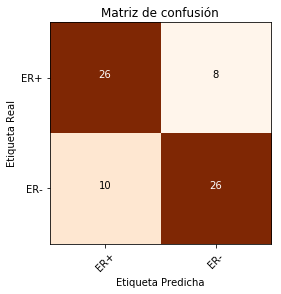

In [6]:
pred_y = modelo.predict(X_test)
validacion_modelo(y_test, pred_y)